### Notebook to develop threshold for modified NDSI (MNDSI) for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

December 2021

### Import packages

In [1]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import earthpy.spatial as es
import matplotlib.pyplot as plt
import matplotlib

### Define paths to directories

In [2]:
# base directory
base_path = '/Users/raineyaberle/Research/PhD/Wolverine/'
# image directory
im_path = base_path+'imagery/Planet/2021-04-20_2021-08-25/adjusted-radiometry/'
# output folder
out_path = base_path+'imagery/Planet/2021-04-20_2021-08-25/SCA/'

### Load Area of Interest (AOI), snowline, and transect shapefiles

In [27]:
# Define EPSG code
epsg = 32606

# Load shapefile
fn = base_path+'GIS_data/wolverine_RGI.shp'
AOI = gpd.read_file(fn)
# Reproject to imagery CRS if necessary
AOI = AOI.to_crs(epsg)
# print info
print('AOI CRS -',AOI.crs)

# Snowline
sl_fn = base_path+'GIS_data/digitized_snowline_picks/20210821_snowline.shp'
sl = gpd.read_file(sl_fn) # snowline
# Reproject to imagery CRS if necessary
sl = sl.to_crs(epsg)
# print info
print('Snowline CRS -',sl.crs)

# Transect 
ts_fn = base_path+'GIS_data/digitized_snowline_picks/transect.shp'
ts = gpd.read_file(ts_fn) # snowline
# reproject to imagery CRS if necessary
ts = ts.to_crs(32606)
# extract transect points from geometry
ts_pts = [i for i in ts.geometry]
ts_x,ts_y = ts_pts[0].coords.xy
ts_x = np.array([x for x in ts_x])
ts_y = np.array([y for y in ts_y])
ts_coords = np.dstack((ts_x,ts_y)).tolist()
# print information
print('Transect CRS -',ts.crs)

AOI CRS - epsg:32606
Snowline CRS - epsg:32606
Transect CRS - epsg:32606


### Plot MNDSI along transect for each image

$ MNDSI = \frac{\rho_G - \rho_{NIR}}{\rho_G + \rho_{NIR}} $

/Users/raineyaberle/opt/anaconda3/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in double_scalars
  n_diff = (b1 - b2) / (b1 + b2)
/Users/raineyaberle/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


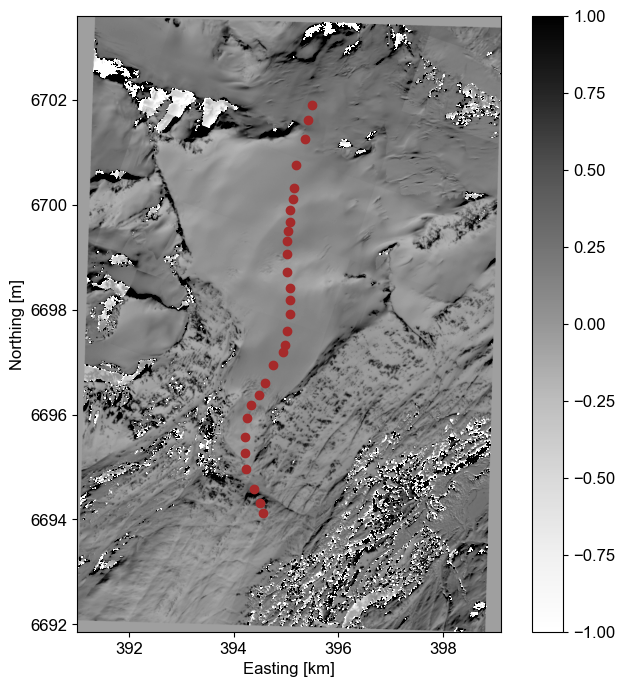

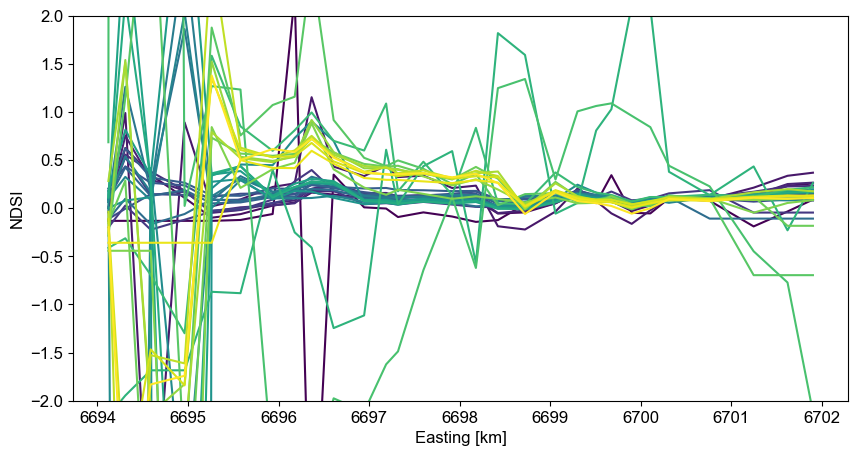

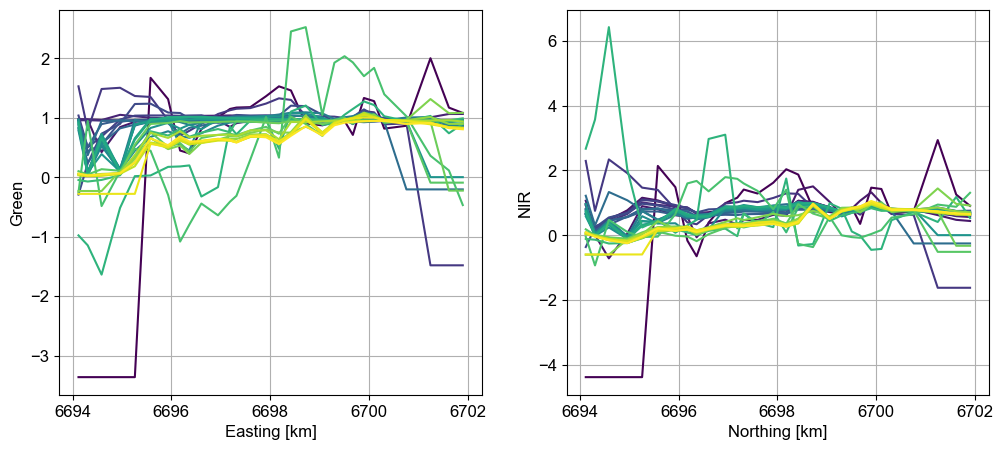

In [42]:
# -----Grab image names
os.chdir(im_path) # change directory
im_names = glob.glob('*.tif')
im_names.sort() # sort file names by date

# -----Set up figures
fig1, ax1 = plt.subplots(1,1,figsize=(8,8))
plt.rcParams.update({'font.size': 12, 'font.sans-serif': 'Arial'})
ax1.set_xlabel('Easting [km]')
ax1.set_ylabel('Northing [m]')
fig2, ax2 = plt.subplots(1,1, figsize=(10,5))
plt.rcParams.update({'font.size': 12, 'font.sans-serif': 'Arial'})
ax2.set_xlabel('Easting [km]')
ax2.set_ylabel('NDSI')
ax2.grid()
fig3, (ax3, ax4) = plt.subplots(1,2,figsize=(12,5))
plt.rcParams.update({'font.size': 12, 'font.sans-serif': 'Arial'})
ax3.set_xlabel('Easting [km]')
ax3.set_ylabel('Green')
ax3.grid()
ax4.set_xlabel('Northing [km]')
ax4.set_ylabel('NIR')
ax4.grid()
# color scheme for plotting lines in loop
colors = plt.cm.viridis(np.linspace(0,1,len(im_names)))  

# -----Loop through images
dates = []
i = 0 # index for color plotting
for im_name in im_names:
        
    # open image
    im = rio.open(im_name)

    # extract date from image name
    date = im_name[0:4] + '-' + im_name[4:6] + '-' + im_name[6:8]
    dates = dates + [np.datetime64(date)]

    # define bands 
    b = im.read(1).astype(float) 
    g = im.read(2).astype(float) 
    r = im.read(3).astype(float) 
    nir = im.read(4).astype(float) 
    # compute MNDSI
    mndsi = es.normalized_diff(g, nir) 
    
    # define coordinates grid
    x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
    y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])

    # sample raster values at transect coordinates
    ts_rv = [x for x in im.sample(ts_coords[0])]
    # calculate MNDSI at points
    ts_green = []
    ts_nir = []
    ts_mndsi = []
    for s in ts_rv:
        ts_mndsi = ts_mndsi + [es.normalized_diff(s[1].astype(float), s[3].astype(float))]
        ts_green = ts_green + [s[1].astype(float)]
        ts_nir = ts_nir + [s[3].astype(float)]
        
    # plot first image and transect points
    if i==3:
        IM = ax1.imshow(mndsi, extent=(np.min(x)/1000, np.max(x)/1000, np.min(y)/1000, np.max(y)/1000),
                  vmin=-1, vmax=1, cmap='Greys')
        ax1.scatter(ts_x/1000, ts_y/1000, color='brown')
        
    # plot values 
    ax2.plot(ts_y/1000, ts_mndsi, label=date, color=colors[i])
    ax3.plot(ts_y/1000, ts_green, label=date, color=colors[i])
    ax4.plot(ts_y/1000, ts_nir, label=date, color=colors[i])

    # increase counter
    i+=1 

# ax2.legend(loc=(1.04,0.0))
ax2.grid()
ax2.set_ylim(-2, 2)
plt.colorbar(IM, ax=ax1)
plt.show()

### Identify snow by adjusting thresholds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


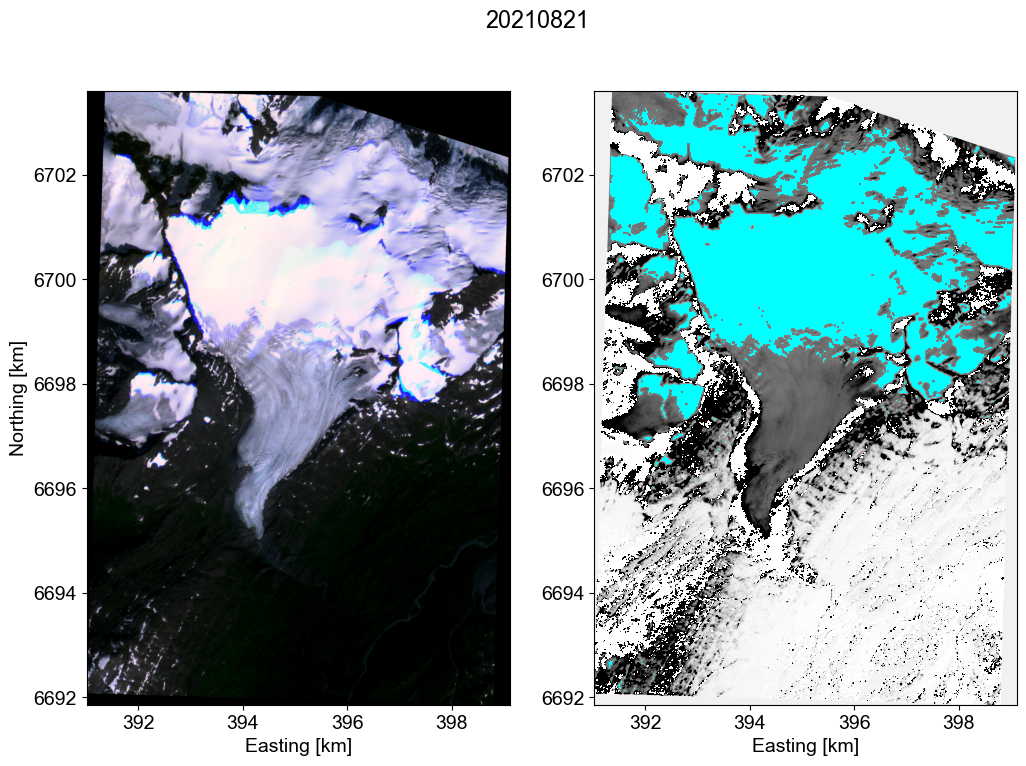

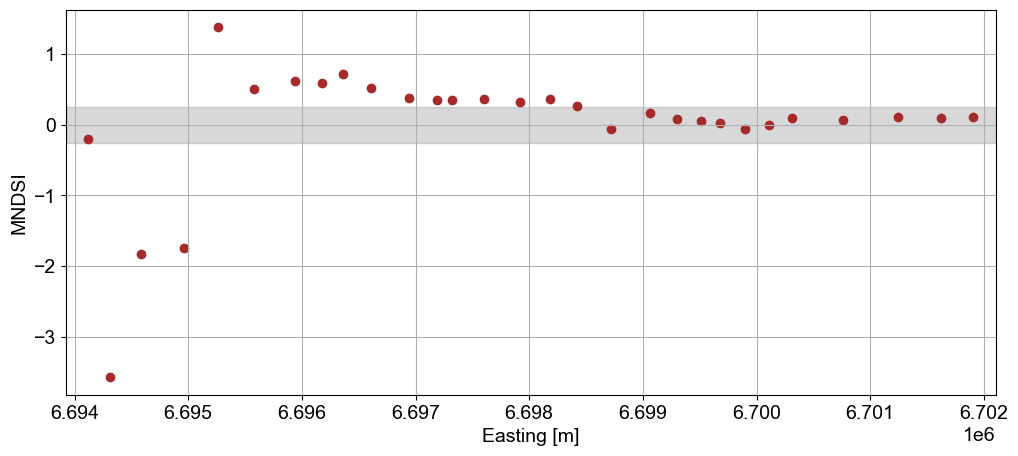

In [58]:
# Determine thresholds
mndsi_thresh = [-0.26, 0.25]

# threshold MNDSI to determine snow cover
snow = np.where((mndsi > np.min(mndsi_thresh)) & (mndsi < np.max(mndsi_thresh)),1,np.nan)

# plot 
fig3, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# RGB image
ax1.imshow(np.dstack([r, g, b]), extent=(np.min(x)/1000, np.max(x)/1000, np.min(y)/1000, np.max(y)/1000))
ax1.set_xlabel('Easting [km]')
ax1.set_ylabel('Northing [km]')
# MNDSI and snow
ax2.imshow(mndsi, extent=(np.min(x)/1000, np.max(x)/1000, np.min(y)/1000, np.max(y)/1000), 
           vmin=-1, vmax=1, cmap='Greys')
ax2.imshow(snow, extent=(np.min(x)/1000, np.max(x)/1000, np.min(y)/1000, np.max(y)/1000), cmap='cool')
ax2.set_xlabel('Easting [km]')
plt.suptitle(im_name[0:8])

# MNDSI values along transect
fig4, ax1 = plt.subplots(1,1, figsize=(12,5))
ax1.set_xlim(np.min(ts_y)-200, np.max(ts_y)+200)
rect=matplotlib.patches.Rectangle((ax1.get_xlim()[0], np.min(mndsi_thresh)),
                                  ax1.get_xlim()[1] - ax1.get_xlim()[0], 
                                  np.max(mndsi_thresh) - np.min(mndsi_thresh), 
                                  fill=True, color="grey", alpha=0.3, label='threshold')
plt.gca().add_patch(rect)
ax1.scatter(ts_y, ts_mndsi, color='brown', label='Transect')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('MNDSI')
#ax1.set_ylim(-0.5,0.5)
ax1.grid()
plt.show()